# This notebook recreates data, analysis, and plots from Higdon et al. 2008 'Computer Model Calibration Using High-Dimensional Output'

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab

import os
import numpy as np
from scipy.interpolate import interp2d
from copy import deepcopy
import pickle
import random

from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData as SepiaData
import sepia.SepiaPlot as SepiaPlot

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from nedderimp import nedderimp

def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return(d)
def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### simulation design

In [15]:
cachefile_name='pkls/nedderDesign.pkl'
if os.path.isfile(cachefile_name):
    design=pickle.load(open(cachefile_name, "rb" ))
else:
    design = np.array([
        [0.7714,    0.4286,    0.0286],
        [0.3714,    0.1143,    0.7143],
        [0.1714,    0.4571,    0.8857],
        [0.3429,    0.6000,    0.8000],
        [0.8000,    0.6286,    0.4000],
        [0.7429,    0.5429,         0],
        [0.6571,    1.0000,    0.6286],
        [0.2857,         0,    0.4571],
        [0.5143,    0.9429,    0.2286],
        [0.6857,    0.3143,    0.6571],
        [0.8286,    0.2000,    1.0000],
        [0.9714,    0.3429,    0.6000],
        [0.4000,    0.8000,    0.2000],
        [0.5429,    0.2857,    0.2857],
        [0.9143,    0.8857,    0.2571],
        [0.0571,    0.0286,    0.0857],
        [0.1143,    0.5714,    0.7429],
        [0.2000,    0.2286,    0.3714],
        [0.4571,    0.9143,    0.3429],
        [0.6286,    0.7143,    0.6857],
        [     0,    0.8286,    0.9429],
        [0.8857,    0.0857,    0.9714],
        [0.2286,    0.0571,    0.5714],
        [0.7143,    0.1714,    0.8571],
        [0.2571,    0.4857,    0.1429],
        [0.5714,    0.4000,    0.8286],
        [0.9429,    0.6857,    0.4857],
        [0.4857,    0.1429,    0.1143],
        [1.0000,    0.8571,    0.9143],
        [0.6000,    0.6571,    0.5143],
        [0.1429,    0.7429,    0.5429],
        [0.8571,    0.2571,    0.0571],
        [0.3143,    0.3714,    0.4286],
        [0.4286,    0.7714,    0.7714],
        [0.0286,    0.9714,    0.3143],
        [0.0857,    0.5143,    0.1714]])
    pickle.dump(design,open( cachefile_name, "w+b" ))
# number of experiements and simulations
n = 3; m = design.shape[0]

# these parameter values simulate expt 10 in Neddermeyer '43
# params =             [R1      lam     s         rho   mratio   u0]
params10 = np.array([1.5*2.54, 2/3,  3e5*6.84e4,  7.5,   .32,   1.65e10])
paramslhs = np.zeros((m, 6))
for i in range(m):#
    paramslhs[i,:] = params10*np.array([1, 1, design[i,1]*.2+.9, 1, design[i,0]*.65+.5, design[i,2]*.2+.9])
# the simulation runs will vary mratio from .32*[.5 to 1.15]
#                                s      from s0*[.9 to 1.1]
#                                u0     from u0*[.9 to 1.1]

### A plot of the implosion over time

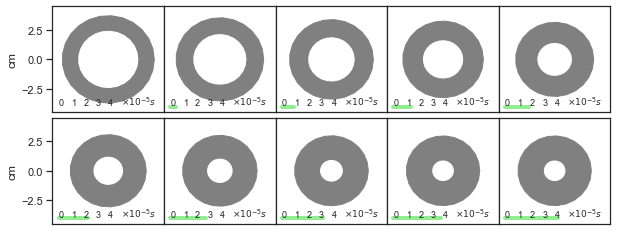

In [16]:
nt = 22; nphi = 26
time = np.c_[np.linspace(0,5.0e-5,nt,endpoint=True)]
phi = np.linspace(0,1,nphi,endpoint=True) * 2*np.pi;
rinner = nedderimp(time,params10);
lam = params10[1]; R1 = params10[0];
router = np.sqrt(rinner**2 + 1 - lam**2);
xycirc = np.array([np.cos(phi),np.sin(phi)]).T
r = nedderimp(time,params10);

fig, axs = plt.subplots(2,5,figsize=[10,4])
tframes = np.arange(1,nt,2)
time_text = ['0','1','2','3','4',r'$\times 10^{-5} s$']
time_x_loc = np.arange(-4,2,1)
time_y_loc = -3.9
for j,ax in enumerate(axs.flatten()):
    it = tframes[j]
    outer_circle = xycirc*router[it]*R1
    ax.fill(outer_circle[:,0],outer_circle[:,1],c='gray')
    inner_circle = xycirc*rinner[it]*R1
    ax.fill(inner_circle[:,0],inner_circle[:,1],c='white')
    ax.set_xlim([-4.5,4.5]); ax.set_ylim([-4.5,4.5])
    for i in range(len(time_text)):
        ax.text(time_x_loc[i],time_y_loc,time_text[i],fontsize=9)
    ax.plot((time[0:it]/(6e-5)*6)-4,np.repeat(-4,time[0:it].shape[0]),'lightgreen',linewidth=4)
    ax.get_xaxis().set_ticks([])
    if j == 0 or j == 5: ax.set_ylabel('cm')
    else: ax.get_yaxis().set_visible(False)
        
plt.subplots_adjust(wspace=0,hspace=0.05)
plt.savefig('plots/nedderdata.png',dpi=300,bbox_inches='tight')
plt.show()

# Generate simulation data

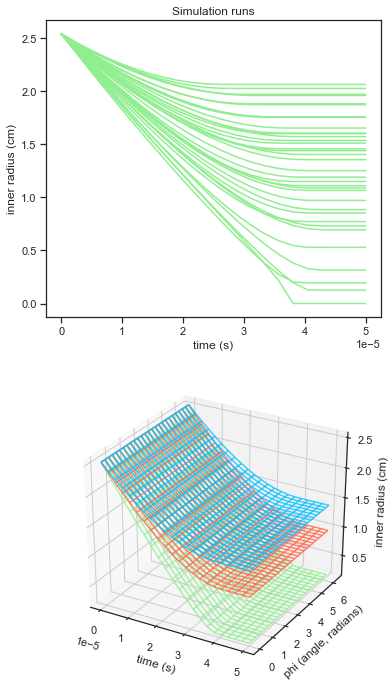

In [17]:
fig = plt.figure(figsize=[6,12])
ax1 = fig.add_subplot(211)
yr = np.zeros((m,nt))
for i in range(m):
    params = paramslhs[i,:]
    yr[i,:] = params[0]*nedderimp(time,params)
    ax1.plot(time,yr[i,:],c='lightgreen')
ax1.set_xlabel('time (s)'); ax1.set_ylabel('inner radius (cm)')
ax1.set_title('Simulation runs')

y_sim = np.tile(yr,nphi)
ax2 = fig.add_subplot(212, projection='3d')
example_runs = [0,1,28]
colors = ['tomato','deepskyblue','lightgreen']
for i in range(len(example_runs)):
    ax2.plot_wireframe(time,phi,y_sim[example_runs[i],:].reshape(nt,nphi,order='F'),color=colors[i],alpha=.75)
ax2.set_xlabel('time (s)'); ax2.set_ylabel('phi (angle, radians)'); ax2.set_zlabel('inner radius (cm)')

plt.savefig('plots/neddersims.png',dpi=300,bbox_inches='tight')
plt.show()
# indices
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(time,26)
y_sim_ind_time_phi[:,1] = np.tile(phi,22)
x_sim = design[:,0].reshape(m,1)
t_sim = design[:,1:3]

# Generate observed data

In [18]:
phi_obs = np.arange(0,(2*np.pi-.1),(2*np.pi/16))
n_phi_obs = phi_obs.shape[0]
time_obs = [np.array([1.5e-5, 2.7e-5, 4.5e-5]),np.array([4.5e-5]),np.array([2.5e-5, 4.5e-5])]
n_time_obs = [tmp.shape[0] for tmp in time_obs]

phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
pphiknots = len(phiknots)
Ddelt = np.zeros((phi_obs.shape[0], pphiknots));
datadelt = np.matmul(Ddelt,dknots)

# observations
r_obs = [None]*3; y_obs = [None]*3
for i in range(3):
    obs_params = deepcopy(params10)
    if i==1: obs_params[4]=.17
    elif i==2: obs_params[4]=.36
    r_obs[i] = np.atleast_2d(obs_params[0]*nedderimp(time_obs[i],obs_params))
    y_obs[i] = np.tile(r_obs[i].T,phi_obs.shape[0]).reshape(n_phi_obs,n_time_obs[i]) + np.tile(datadelt,n_time_obs[i])
    y_obs[i] = (y_obs[i] + .01*np.random.normal(size=y_obs[i].shape)).flatten()

# indices of observations
x_obs = ((np.array([params10[4], .17, .36])/.32-.5)/.65).reshape(3,1)
y_ind_obs = [np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[0][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[0][1],\
                                       np.ones(phi_obs.shape[0])*time_obs[0][2])), np.tile(phi_obs,3).T ) ),
                np.column_stack( ( (np.ones(phi_obs.shape[0])*time_obs[1]).reshape(16,1), phi_obs.T ) ),
                np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[2][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[2][1])), np.tile(phi_obs,2).T ) )]

### Sepia Data

In [19]:
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_sim = y_sim, y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs, y_ind_obs = y_ind_obs)
data.transform_xt()

(None, None)

### K basis

In [20]:
# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
phimat = np.repeat(phi,nt).reshape((nt,nphi),order='F')
timemat = np.repeat(time,nphi).reshape((nt,nphi))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((nt,nphi),order='F'))
data.obs_data.orig_y_mean = []
data.obs_data.orig_y_sd = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    data.obs_data.orig_y_sd.append(data.sim_data.orig_y_sd)

# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

# for now, hack this in - if it used the inbuilt methods it would happen automatically
data.obs_data.Sigy_std = data.obs_data.Sigy

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(nt,nphi),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

### D basis

In [21]:
# compute the basis functions for the discrepancy function.
Dobs = []
Dsim  = np.zeros((phi.shape[0], pphiknots))
for k in range(pphiknots):
    Ddelt[:,k] = dnorm(dist2pi(phi_obs,phiknots[k]*np.ones(phi_obs.shape[0])),0,np.pi/8).T;
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[0])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)

simdelt = np.matmul(Dsim,dknots)
timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs.append(np.zeros((pv,data.obs_data.y_std[k].shape[0])))
    if k == 0: Dsim = np.zeros((pv,data.sim_data.y_std.shape[1]))
    for j in range(pv):
        Dobs[-1][j,:] = dnorm(y_ind_obs[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(y_ind_obs[k][:,1],knotlocsphi[j]*np.ones(y_ind_obs[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[j,:] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)

data.create_D_basis(D_obs=Dobs,D_sim=Dsim)

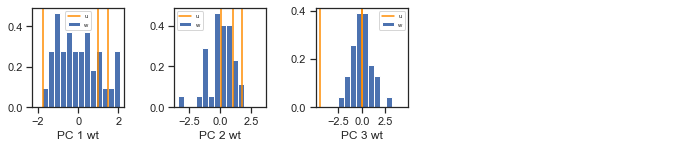

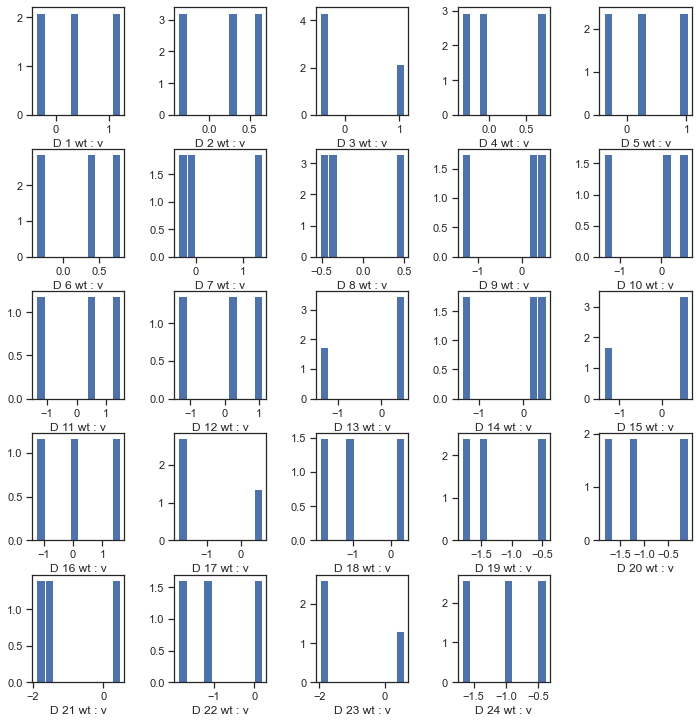

In [22]:
fig_uw, fig_v = data.plot_K_weights()

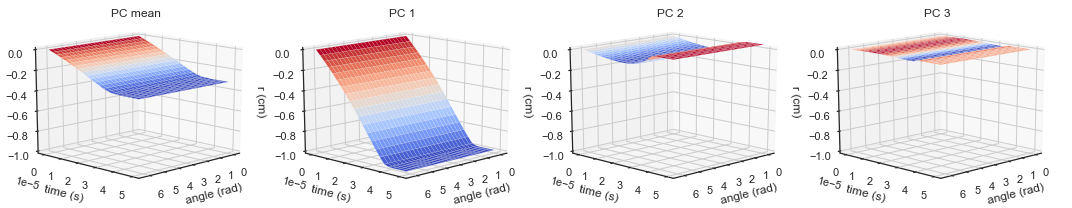

In [23]:
# plot K basis (simulation)
from matplotlib import cm
x,y = np.meshgrid(phi,time)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,3),tight_layout=True)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    if i == 0:
        ax.plot_surface(x,y,np.mean(data.sim_data.K,0).reshape((22,26),order='F'),cmap=cm.coolwarm,linewidth=.1)
        ax.set_title('PC mean')
    else:
        ax.plot_surface(x,y,data.sim_data.K[i-1,:].reshape((22,26),order='F'),cmap=cm.coolwarm,linewidth=.1)
        ax.set_title('PC {}'.format(i))
    ax.set_ylabel('time (s)'); ax.set_xlabel('angle (rad)'); ax.set_zlabel('r (cm)')
    ax.set_zlim([-1,0])
    ax.view_init(15, 45)
plt.savefig('plots/nedder_k_basis.png',dpi=300,bbox_inches='tight')

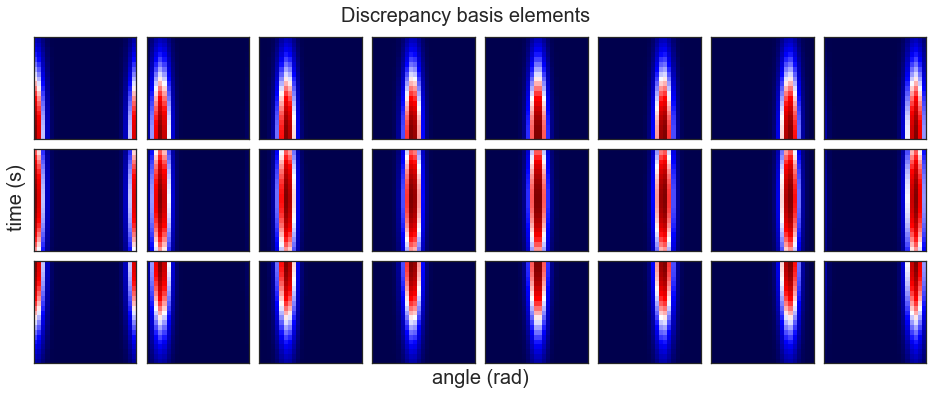

In [24]:
# plot D basis
fig, axs = plt.subplots(3,8,figsize=[16,6],sharex=True,sharey=True)
x,y = np.meshgrid(phi,time)
for i,ax in enumerate(axs.flatten()):
    ax.pcolormesh(x, y, data.sim_data.D[i,:].reshape((22,26),order='F'),cmap='seismic')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.xlabel(r"angle \phi")
plt.ylabel("time")
plt.subplots_adjust(hspace=.1,wspace=.1)
plt.suptitle('Discrepancy basis elements',y=.95,fontsize=20)
plt.text(-50,.000067,'time (s)',rotation='vertical',fontsize=20)
plt.text(-24,-.00001,'angle (rad)',fontsize=20)
plt.savefig('plots/nedder_d_basis.png',dpi=300,bbox_inches='tight')
plt.show()

/Users/gatt/.conda/envs/sepia/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gatt/.conda/envs/sepia/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gatt/.conda/envs/sepia/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

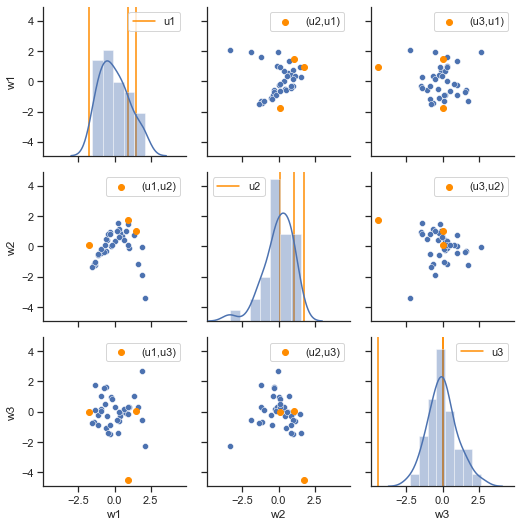

In [25]:
fig_uw_pairs = data.plot_u_w_pairs(save='plots/uw_pairs.png')

In [26]:
model = SepiaModel(data)
pickle.dump(data,open('pkls/nedderData.pkl','w+b'))
override = 0
cachefile_name='pkls/neddermeyer'
if os.path.isfile(cachefile_name+'.pkl') and override==0:
    model.restore_model_info(cachefile_name)
else:
    random.seed(42)
    model.tune_step_sizes(50, 20, update_vals=True)
    model.do_mcmc(5000)
    model.save_model_info(cachefile_name)

MCMC sampling: 100%|██████████| 5000/5000 [01:11<00:00, 70.34it/s]


Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1070.4530755]]
Done with tune_step_size.
Selected step sizes:
theta
[[0.11408802 0.15522503]]
betaV
[[0.9208827]]
betaU
[[0.86957473 0.36544977 0.56854877]
 [0.04625059 0.80483261 0.55074388]
 [0.0766403  0.5139621  0.62153886]]
lamVz
[[9638.45935748]]
lamUz
[[1.03748111 0.5616356  1.01335287]]
lamWs
[[4856.82427398 4591.17933358 3917.58302905]]
lamWOs
[[3990.60310097]]
lamOs
[[4389.14491195]]
Model saved to pkls/neddermeyer.pkl


In [27]:
samples_dict = model.get_samples()
p_stats = SepiaPlot.param_stats(samples_dict,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                      mean         sd  0.05 quantile  0.95 quantile
theta_1             0.5167     0.0224         0.4786         0.5524
theta_2             0.4713     0.0337         0.4152         0.5267
betaV               1.1432     2.3033         0.0029         5.7284
betaU_1             1.9867     0.7623         1.0145         3.3981
betaU_2             0.0604     0.0379         0.0203         0.1323
betaU_3             0.0979     0.0621         0.0327         0.2211
betaU_4            10.3434     2.7878         6.4415        15.1394
betaU_5             1.5776     0.7460         0.7224         2.9906
betaU_6             0.7344     0.3200         0.3181         1.3054
betaU_7             8.6047     5.3646         3.0791        20.1896
betaU_8            11.1869     5.8603         2.5622        20.4758
betaU_9             0.9785     0.6780         0.1132         2.1964
lamVz            1846.5194  1204.4758       492.1851      4191.9118
lamUz_1             0.4968     0.1607         0.

/Users/gatt/.conda/envs/sepia/lib/python3.7/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


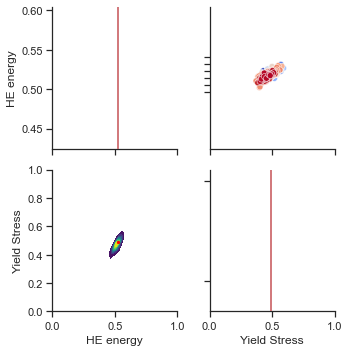

In [28]:
theta_pairs = SepiaPlot.theta_pairs(samples_dict, native=False,\
                      design_names=['HE energy','Yield Stress'],theta_ref=[0.5217,0.4874],save='plots/theta_pairs.png')

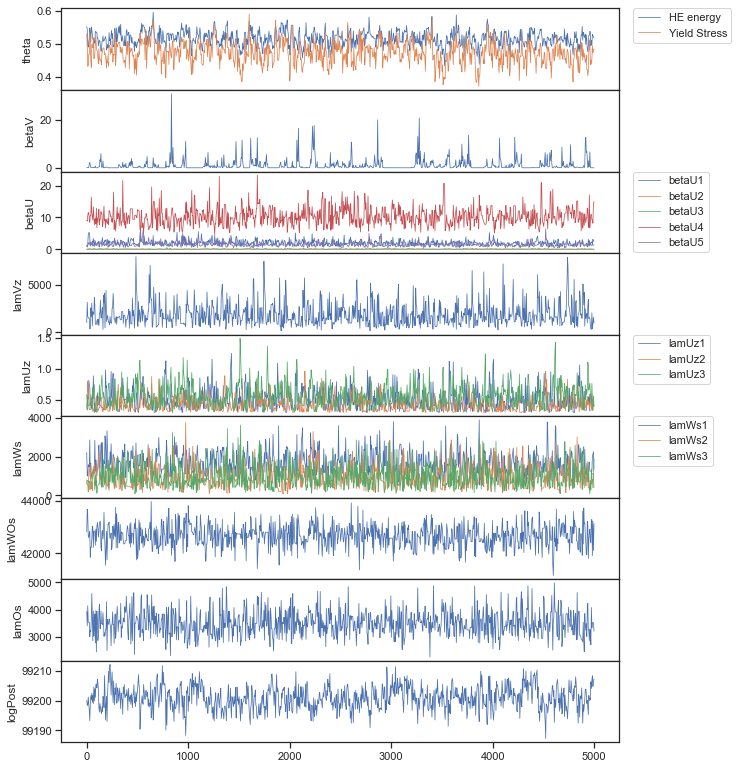

In [29]:
mcmc_trace = SepiaPlot.mcmc_trace(samples_dict,start=0,n_to_plot=1000,\
                                  theta_names=['HE energy','Yield Stress'],max_print=5,by_group=True)

# Predictions

In [30]:
model.verbose=True
from sepia.SepiaPredict import SepiaEmulatorPrediction 
# get ESS number of samples for preduction
pred_samples=model.get_samples(nburn=0,effectivesamples=True)
pred=SepiaEmulatorPrediction(x_pred=x_obs, samples=pred_samples, model=model)

Max effective sample size over thetas: 261
Total samples: 5000


### Predicted emulator principal component weights for each of the three experimental inputs x

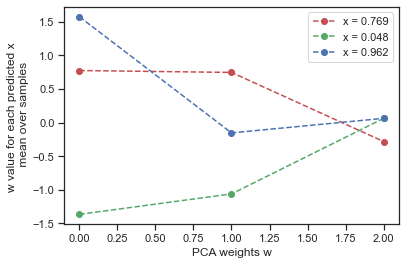

In [31]:
predw=pred.get_w()
plt.figure()
colors = ['r','g','b']
for i in range(3):
    plt.plot(np.mean(predw,0).T[:,i],'--o',c=colors[i],label='x = {}'.format(np.round(float(x_obs[i]),3)))
plt.legend()
plt.xlabel('PCA weights w')
plt.ylabel('w value for each predicted x \n mean over samples')
plt.show()

### Predicted Simulator Output

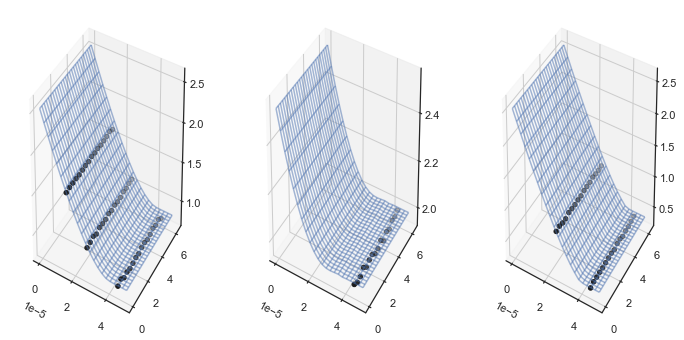

In [32]:
pred_time, pred_phi = np.meshgrid(time,phi)
predy=pred.get_y()

fig = plt.figure(figsize=[12,6])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    ax.scatter(xs = y_ind_obs[i][:,0], ys = y_ind_obs[i][:,1], zs = y_obs[i],color='k')
    ax.plot_wireframe(pred_time,pred_phi,np.mean(predy,0)[i,:].reshape(26,22),
                      alpha=.5)

### Full Predictions (emulator + discrepancy)

In [33]:
from sepia.SepiaPredict import SepiaFullPrediction
predfull = []
for i in range(3):
    predfull.append(SepiaFullPrediction(x_pred=np.atleast_2d(x_obs[i]), samples=pred_samples, model=model))

In [34]:
pred_d = []
pred_sim = []
pred_obs = []
for i in range(3):
    pred_d.append(predfull[i].get_discrepancy())
    pred_sim.append(predfull[i].get_ysim())
    pred_obs.append(predfull[i].get_yobs())
sim_grid_shape = (26,22)

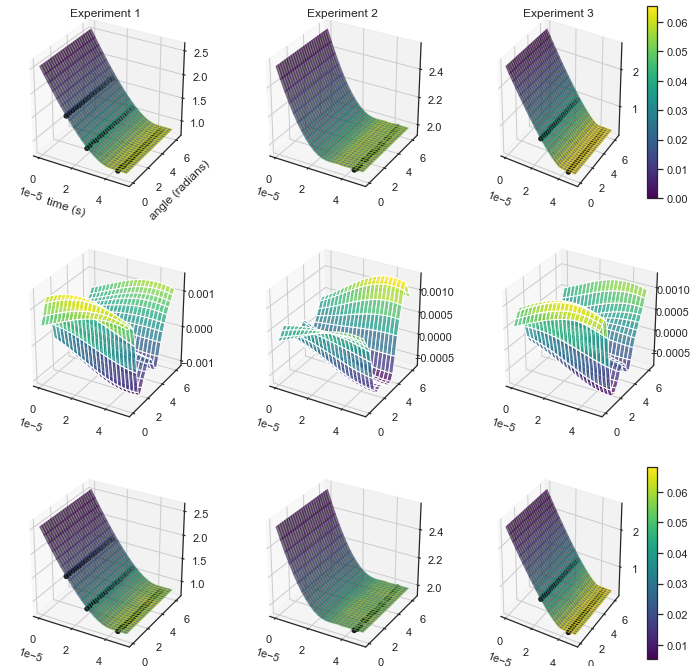

In [35]:
from matplotlib import cm
full_pred = [None]*n
quant_diff_full = [None]*n
quant_diff_sim = [None]*n
for i in range(n):
    full_pred[i] = pred_sim[i] + pred_d[i]
    # quantile range
    quant_diff_full[i] = np.abs(np.quantile(full_pred[i],.95,0)-np.quantile(full_pred[i],.05,0))
    quant_diff_sim[i]  = np.abs(np.quantile(pred_sim[i],.95,0)-np.quantile(pred_sim[i],.05,0))
    
# color sim surface by uncertainty
c_min = min([np.amin(tmp) for tmp in quant_diff_sim[i]])
c_max = max([np.amax(tmp) for tmp in quant_diff_sim[i]])
norm = plt.Normalize(c_min, c_max)
colors_sim = [None]*n
for i in range(n):
    colors_sim[i] = cm.viridis(norm(quant_diff_sim[i])).squeeze()
    colors_sim[i] = colors_sim[i].reshape((26,22,4))
cmap_sim = cm.ScalarMappable(cmap='viridis', norm=norm)
cmap_sim.set_array([])
    
# color full surface by uncertainty
c_min = min([np.amin(tmp) for tmp in quant_diff_full[i]])
c_max = max([np.amax(tmp) for tmp in quant_diff_full[i]])
norm = plt.Normalize(c_min, c_max)
colors_full = [None]*n
for i in range(n):
    colors[i] = cm.viridis(norm(quant_diff_full[i])).squeeze()
    colors[i] = colors[i].reshape((26,22,4))  
cmap_full = cm.ScalarMappable(cmap='viridis', norm=norm)
cmap_full.set_array([])
    
fig = plt.figure(figsize=[12,12])
for i in range(9):
    ax = fig.add_subplot(3,3,i+1,projection='3d')
    if i in [0,1,2]:
        ax.scatter(xs = y_ind_obs[i][:,0], ys = y_ind_obs[i][:,1], zs = y_obs[i],color='k')
        if i == 0: ax.set_xlabel('time (s)'); ax.set_ylabel('angle (radians)'); 
        ax.set_title('Experiment {}'.format(i+1))
        surf = ax.plot_surface(pred_time,pred_phi,np.mean(pred_sim[i],0).reshape(sim_grid_shape), shade=False, alpha=.5, facecolors=colors_sim[i])
        surf.set_facecolor((0,0,0,0))
        if i == 2: plt.colorbar(cmap_sim)
    elif i in [3,4,5]:
        ax.plot_surface(pred_time,pred_phi,np.mean(pred_d[i-3],0).reshape(sim_grid_shape),alpha=.75, shade=False, cmap = 'viridis')
    else:
        ax.scatter(xs = y_ind_obs[i-6][:,0], ys = y_ind_obs[i-6][:,1], zs = y_obs[i-6],color='k')
        surf = ax.plot_surface(pred_time,pred_phi,np.mean(full_pred[i-6],0).reshape(sim_grid_shape), shade=False, alpha=.5,facecolors=colors[i-6])
        surf.set_facecolor((0,0,0,0))
        if i == 8: plt.colorbar(cmap_full)
plt.show()

# Save a bunch of data for testing purposes

The following is in place soley for comparisons with matlab analysis from GPMSA and can be ignored by the reader

In [36]:
# make a .mat file so we can compare SEPIA to GPMSA
mat = {}
mat['ye']=data.sim_data.y.T
mat['Xlhs']=design
mat['ysimmean']=np.atleast_2d(ysimmean).T
mat['ysimsd']=data.sim_data.orig_y_sd
mat['ysimStd']=data.sim_data.y_std.T
mat['Ksimpy']=data.sim_data.K.T
mat['time']=time
mat['phi']=phi
mat['timearr']=timemat
mat['phiarr']=phimat
mat['ydat1']=data.obs_data.y[0].reshape((16,3),order='F')
mat['ydat2']=data.obs_data.y[1]
mat['ydat3']=data.obs_data.y[2].reshape((16,2),order='F')
mat['origtime1']=np.atleast_2d(data.obs_data.y_ind[0][:,0]).T
mat['origtime2']=np.atleast_2d(data.obs_data.y_ind[1][:,0]).T
mat['origtime3']=np.atleast_2d(data.obs_data.y_ind[2][:,0]).T
mat['origphi1']=np.atleast_2d(data.obs_data.y_ind[0][:,1]).T
mat['origphi2']=np.atleast_2d(data.obs_data.y_ind[1][:,1]).T
mat['origphi3']=np.atleast_2d(data.obs_data.y_ind[2][:,1]).T
mat['xdat']=data.obs_data.x
mat['origymean1']=np.atleast_2d(data.obs_data.orig_y_mean[0]).T
mat['origymean2']=np.atleast_2d(data.obs_data.orig_y_mean[1]).T
mat['origymean3']=np.atleast_2d(data.obs_data.orig_y_mean[2]).T
mat['origyStd1']=np.atleast_2d(data.obs_data.y_std[0]).T
mat['origyStd2']=np.atleast_2d(data.obs_data.y_std[1]).T
mat['origyStd3']=np.atleast_2d(data.obs_data.y_std[2]).T
mat['Kobs1']=data.obs_data.K[0].T
mat['Kobs2']=data.obs_data.K[1].T
mat['Kobs3']=data.obs_data.K[2].T
mat['Dsimpy']=data.sim_data.D.T
mat['knotlocstime']=knotlocstime
mat['knotlocsphi']=knotlocsphi
mat['Dobs1']=data.obs_data.D[0].T
mat['Dobs2']=data.obs_data.D[1].T
mat['Dobs3']=data.obs_data.D[2].T

#mat['datadelt'] = datadelt
#mat['Ddelt'] = Ddelt
#mat['dknots'] = dknots
#mat['Dsim'] = Dsim
#mat['lam']=lam
#mat['m'] = float(m)
#mat['ndat1']=phi_obs.shape[0]
#mat['np']=nphi
#mat['nt']=nt
#mat['params']=params
#mat['params10']=params10
#mat['paramsdat1']=params10
#mat['paramsdat2']=params10
#mat['paramsdat2'][4]=.17
#mat['paramsdat3']=params10
#mat['paramsdat3'][4]=.36
#mat['paramslhs']=paramslhs
#mat['phidat']=phi_obs
#mat['phiknots']=phiknots
#mat['pphiknots']=pphiknots
#mat['timeknots']=timeknots
#mat['ptimeknots']=ptimeknots
#mat['r']=r
#mat['R1']=R1
#mat['rdat1']=r_obs[0]
#mat['rdat2']=r_obs[1]
#mat['rdat3']=r_obs[2]
#mat['rinner']=rinner
#mat['rout1']
#mat['rout2']
#mat['rout3']
#mat['router']=router
#mat['rsim1']
#mat['rsim2']
#mat['rsim3']
#mat['rsimout1']
#mat['rsimout2']
#mat['rsimout3']
#mat['simdelt']=simdelt
#mat['tend']=5e-5
#mat['timedat1']=time_obs[0]
#mat['timedat2']=time_obs[1]
#mat['timedat3']=time_obs[2]
#mat['xcirc']=xycirc[:,0]
#mat['xcircd']
#mat['ycirc']=xycirc[:,1]
#mat['ycircd']
#mat['yearr']=np.reshape(y_sim,(nt,nphi,m))
#mat['yr']=yr.T

In [37]:
from scipy.io import savemat
savemat('../../dev/dev_test/matlab/neddTemp2.mat',mat)

In [38]:
# Make a dictionary of everything we need to rebuild the data and model objects in testing
data_dict = {'x_sim':x_sim, 't_sim':t_sim, 'y_sim':y_sim, 'y_ind_sim':y_sim_ind_time_phi,\
                 'x_obs':x_obs, 'y_obs':y_obs, 'y_ind_obs':y_ind_obs}
data_dict['sim_orig_y_mean']=data.sim_data.orig_y_mean
data_dict['sim_orig_y_sd']=data.sim_data.orig_y_sd
data_dict['sim_y_std']=data.sim_data.y_std
data_dict['Ksim'] = data.sim_data.K
data_dict['obs_orig_y_mean']=data.obs_data.orig_y_mean
data_dict['obs_orig_y_sd']=data.obs_data.orig_y_sd
data_dict['obs_orig_y_std']=data.obs_data.y_std
data_dict['Kobs'] = data.obs_data.K

data_dict['Dobs'] = Dobs
data_dict['Dsim'] = Dsim
pickle.dump(data_dict,open('pkls/nedderDataDict.pkl','w+b'))